In [1]:
import pymc3 as pm

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

%matplotlib inline

In [3]:
#read matches from CSV, data set called df
df = pd.read_csv('matches.csv')
df.head()
teams = list(set(df.home_team)) #get a list of the team names, set gives all unique values
team_ids = {team: count for count, team in enumerate(teams)} #here I can count from 0
data = {'N': len(teams), 'M': len(df)} 
x = df.replace(team_ids)
data.update(df.replace(team_ids))
footballmatch_data = data

In [4]:
len(teams)

16

In [5]:
footballmatch_data

{'M': 161, 'N': 16, 'away_score': 0      0
 1      3
 2      3
 3      1
 4      1
 5      1
 6      3
 7      1
 8      2
 9      2
 10     0
 11     1
 12     2
 13     1
 14     2
 15     3
 16     0
 17     1
 18     1
 19     0
 20     4
 21     2
 22     0
 23     1
 24     2
 25     1
 26     2
 27     1
 28     1
 29     1
       ..
 131    0
 132    1
 133    0
 134    2
 135    1
 136    0
 137    1
 138    2
 139    2
 140    3
 141    0
 142    2
 143    3
 144    1
 145    0
 146    2
 147    0
 148    2
 149    2
 150    1
 151    0
 152    2
 153    2
 154    5
 155    1
 156    1
 157    0
 158    1
 159    0
 160    1
 Name: away_score, Length: 161, dtype: int64, 'away_team': 0       6
 1      11
 2       6
 3       1
 4       2
 5       4
 6       9
 7      10
 8       5
 9       7
 10      8
 11      3
 12     14
 13     15
 14     13
 15      0
 16     11
 17      9
 18     10
 19     15
 20      9
 21      1
 22      7
 23     13
 24      5
 25     12
 26      3
 2

In [6]:
home_team_values = x.home_team.values
away_team_values = x.away_team.values
observed_home_score = x.home_score.values
observed_away_score = x.away_score.values

In [9]:
%%time
with pm.Model() as allsvenskan:
    #define prior
    avg = pm.Normal('avg',mu=0, sd = 1)
    home_adv = pm.Normal('home_adv', mu=0, sd = 1)
    off = pm.Normal('off', mu = 0, sd = 0.5, shape = len(teams))
    defen = pm.Normal('def', mu = 0, sd = 0.5, shape = len(teams)) #can't use def here.
    
    #for m in range(len(df)):
    lambda_home = np.exp(avg + home_adv + off[home_team_values] - defen[away_team_values])
    lambda_away = np.exp(avg - home_adv + off[away_team_values] - defen[home_team_values])        
        
    home_score = pm.Poisson('home_score',mu=lambda_home,observed = observed_home_score)
    away_score = pm.Poisson('away_score',mu=lambda_away,observed = observed_away_score)
        
        

CPU times: user 422 ms, sys: 15.6 ms, total: 438 ms
Wall time: 464 ms


In [10]:
%%time
#The number of tuned samples are discarded by default.
#run 4 chains in parallel, chains = 0 only means to store sample in chain 0
#trace = pm.sample(draws = 600, tune=500), means total sample size = 600, 1 chain.
#above means total sample size = 2400,from 4 chains. additional 500 samles for tuning was drawn and discarded.
with allsvenskan:
    trace = pm.sample(draws = 10000, tune=5000,njobs = 4) #trace contains all samples by orders, 4 chains

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -485.1: 100%|██████████| 200000/200000 [01:14<00:00, 2682.68it/s] 
Finished [100%]: Average ELBO = -485.16
100%|██████████| 10000/10000 [04:48<00:00, 34.69it/s]


CPU times: user 1min 43s, sys: 9.56 s, total: 1min 53s
Wall time: 6min 39s


In [136]:
trace['avg'].shape
trace.nchains
trace.get_values('avg', chains=0).shape # get values of a single chain

(600,)

In [11]:
pm.df_summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
avg,0.169056,0.179664,0.002632,-0.184145,0.520660
home_adv,0.106793,0.049107,0.000173,0.009377,0.201693
off__0,0.225587,0.208218,0.001637,-0.188568,0.624812
off__1,-0.095819,0.222834,0.001607,-0.523844,0.349456
off__2,0.062846,0.216451,0.001779,-0.354766,0.485550
off__3,0.273865,0.202794,0.001609,-0.118988,0.680971
off__4,-0.238228,0.235290,0.001821,-0.698944,0.224749
off__5,0.349437,0.199278,0.001757,-0.035043,0.743124
off__6,0.083767,0.210574,0.001712,-0.331101,0.492357
off__7,0.138361,0.210728,0.001785,-0.267186,0.558168


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f933b10fd68>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f932e1eb198>]], dtype=object)

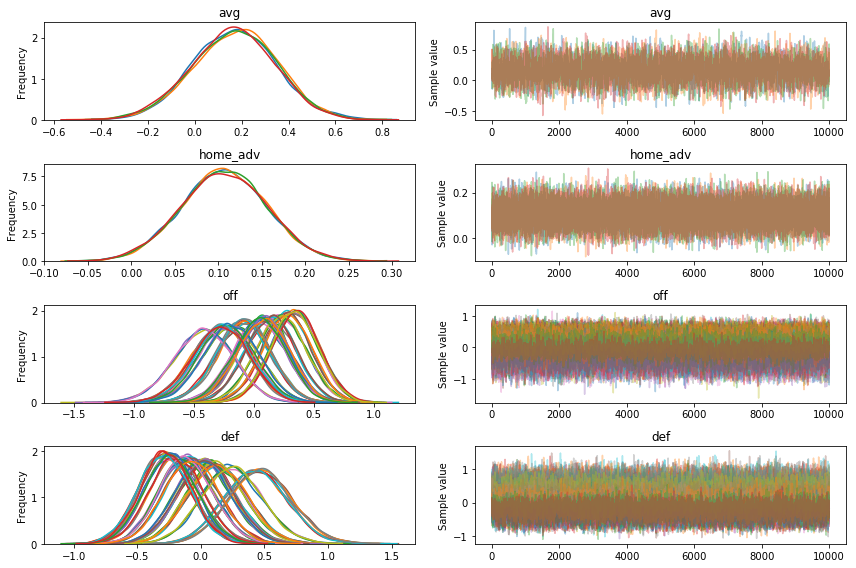

In [12]:
pm.traceplot(trace)
pass

In [13]:
team= x[['home_team', 'away_team']]
score = x[['home_score','away_score']]

In [14]:
#for prediction
import theano

home_team_shared = theano.shared(home_team_values)
away_team_shared = theano.shared(away_team_values)
home_score_shared = theano.shared(observed_home_score)
away_score_shared = theano.shared(observed_away_score)

In [15]:
with pm.Model() as model_predict:
        #define prior
    avg = pm.Normal('avg',mu=0, sd = 1)
    home_adv = pm.Normal('home_adv', mu=0, sd = 1)
    off = pm.Normal('off', mu = 0, sd = 0.5, shape = len(teams))
    defen = pm.Normal('def', mu = 0, sd = 0.5, shape = len(teams)) #can't use def here.
    
    
    lambda_home = np.exp(avg + home_adv + off[home_team_shared] - defen[away_team_shared])
    lambda_away = np.exp(avg - home_adv + off[away_team_shared] - defen[home_team_shared])        
        #likelihood
    home_score = pm.Poisson('home_score',mu=lambda_home,observed = home_score_shared)
    away_score = pm.Poisson('away_score',mu=lambda_away,observed = away_score_shared)




In [16]:
%%time

with model_predict:
    trace = pm.sample(draws = 10000, tune=5000,njobs = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -485.11: 100%|██████████| 200000/200000 [01:27<00:00, 2298.66it/s]
Finished [100%]: Average ELBO = -485.12
100%|██████████| 10000/10000 [08:38<00:00, 19.29it/s]


CPU times: user 1min 55s, sys: 9.8 s, total: 2min 5s
Wall time: 10min 36s


In [17]:
df_new=pd.read_csv('upcoming.csv')
new_data = df_new.replace(team_ids)
len(new_data.home_team)

79

In [18]:
home_team_shared.set_value(new_data.home_team.values)
away_team_shared.set_value(new_data.away_team.values)
home_score_shared.set_value([0]*len(new_data.home_team)) #predicted value has to have the same length as input data
away_score_shared.set_value([0]*len(new_data.home_team))


In [19]:
%%time
#Generate posterior predictive samples from a model given a trace.
#Model (Model (optional if in with context)) – Model used to generate trace
#if you don't like the process bar, you can remove it.
post_pred = pm.sample_ppc(trace, model = model_predict, samples=40000)

100%|██████████| 40000/40000 [34:18<00:00, 19.43it/s] 


CPU times: user 33min 18s, sys: 37.8 s, total: 33min 56s
Wall time: 34min 18s


In [36]:
pm.df_summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
avg,0.169015,0.181320,0.002376,-0.198838,0.514973
home_adv,0.106391,0.049867,0.000196,0.006776,0.201816
off__0,0.224114,0.206564,0.001485,-0.185312,0.621635
off__1,-0.096735,0.225195,0.001581,-0.540317,0.342125
off__2,0.060258,0.215885,0.001500,-0.368988,0.475918
off__3,0.271634,0.203530,0.001568,-0.139883,0.658368
off__4,-0.240699,0.234283,0.001606,-0.706772,0.208891
off__5,0.350004,0.199279,0.001558,-0.044945,0.731625
off__6,0.082479,0.208672,0.001518,-0.336149,0.482769
off__7,0.137081,0.208730,0.001502,-0.280714,0.535559


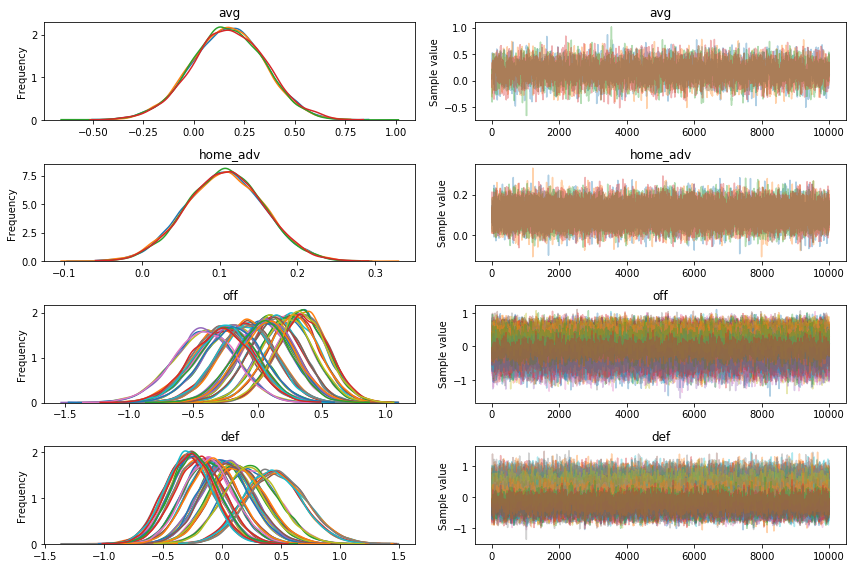

In [35]:
pm.traceplot(trace)
pass

In [37]:
post_pred #40000 samples #79 upcoming games, under each sample, there are 79 upcoming games

{'away_score': array([[0, 2, 1, ..., 3, 3, 2],
        [2, 1, 2, ..., 2, 0, 3],
        [1, 1, 1, ..., 1, 0, 1],
        ..., 
        [0, 1, 2, ..., 1, 0, 2],
        [1, 1, 1, ..., 4, 0, 3],
        [2, 0, 0, ..., 0, 0, 2]]),
 'home_score': array([[0, 2, 4, ..., 1, 0, 1],
        [1, 1, 1, ..., 2, 2, 0],
        [0, 2, 1, ..., 0, 1, 0],
        ..., 
        [0, 1, 3, ..., 1, 3, 1],
        [1, 2, 1, ..., 2, 1, 1],
        [1, 1, 2, ..., 2, 3, 1]])}

In [21]:
#to operate each row from a table
class TableRow:
    def __init__(self, points=0, goals_for=0, goals_against=0):
        self.points = 0
        self.goals_for = 0
        self.goals_against = 0
    #why define a property? You don't need to write tablerow.score_diff(),now you can just tablerow.score_diff.
    #To have the same way as to call other variables, for example, tablerow.points
    @property
    def score_diff(self):
        return self.goals_for - self.goals_against
    #
    #__lt__ tells python howto use comparison operators, if <, return ture.
    def __lt__(self, other):
        if self.points != other.points:
            return self.points < other.points
        if self.score_diff != other.score_diff:
            return self.score_diff < other.score_diff
        return self.goals_for < other.goals_for
    #equality
    def __eq__(self, other):
        return not (self > other or self < other)
    
    #how to represent as a string, mainly for debug
    def __repr__(self):
        return f"TableRow({self.points}, {self.goals_for}, {self.goals_against})"

In [22]:
from collections import defaultdict

In [23]:
#creates a new empty discionary
#instead of raising KeyErrors, it inserts the key
#TableRow is the factory function, it tells you how to create new objects for a dictionary.
#if I put int, I will get zero.
#everything is an object in Python.
table_rows = defaultdict(TableRow)

In [24]:
#df is the passed games, with home score and away score
#how are we using the TableRow class?
#feed the data
for row in df.itertuples():
    home_points = 3*(row.home_score > row.away_score) + (row.home_score == row.away_score)
    away_points = 3*(row.away_score > row.home_score) + (row.home_score == row.away_score)
    table_rows[row.home_team].points += home_points
    table_rows[row.home_team].goals_for += row.home_score
    table_rows[row.home_team].goals_against += row.away_score
    table_rows[row.away_team].points += away_points
    table_rows[row.away_team].goals_for += row.away_score
    table_rows[row.away_team].goals_against += row.home_score

In [25]:
table_rows

defaultdict(__main__.TableRow,
            {'AFC Eskilstuna': TableRow(12, 18, 37),
             'AIK': TableRow(35, 24, 14),
             'Djurgården': TableRow(36, 35, 21),
             'Elfsborg': TableRow(27, 37, 31),
             'Halmstad': TableRow(13, 19, 29),
             'Hammarby': TableRow(29, 30, 25),
             'Häcken': TableRow(32, 23, 15),
             'IFK Göteborg': TableRow(29, 30, 24),
             'IFK Norrköping': TableRow(33, 27, 25),
             'Jönköping': TableRow(19, 20, 34),
             'Kalmar': TableRow(20, 18, 35),
             'Malmö FF': TableRow(46, 38, 18),
             'Sirius': TableRow(33, 32, 22),
             'Sundsvall': TableRow(16, 15, 29),
             'Örebro': TableRow(27, 26, 33),
             'Östersund': TableRow(29, 27, 27)})

In [26]:
from copy import deepcopy

In [27]:
#loop each iteration (2000 iterations)
#define a function to produce a table
def produce_ordered_predicted_table(dataframe):
    copied_played_games_points = deepcopy(table_rows)
    for row in dataframe.itertuples():
        home_points = 3*(row.home_score > row.away_score) + (row.home_score == row.away_score)
        away_points = 3*(row.away_score > row.home_score) + (row.home_score == row.away_score)
        copied_played_games_points[row.home_team].points += home_points
        copied_played_games_points[row.home_team].goals_for += row.home_score
        copied_played_games_points[row.home_team].goals_against += row.away_score
        copied_played_games_points[row.away_team].points += away_points
        copied_played_games_points[row.away_team].goals_for += row.away_score
        copied_played_games_points[row.away_team].goals_against += row.home_score
    sorted_table = [*sorted(copied_played_games_points.items(), key=lambda x: x[1], reverse=True)]
    return sorted_table

In [28]:
df_new_predicted = df_new.assign(home_score = post_pred['home_score'][0],away_score = post_pred['away_score'][0])
df_new_predicted

,home_team,away_team,away_score,home_score
0,AIK,Djurgården,0,0
1,Häcken,Jönköping,2,2
2,IFK Norrköping,Östersund,1,4
3,Kalmar,Sirius,4,4
4,Elfsborg,Halmstad,1,3
5,Malmö FF,IFK Göteborg,1,0
6,Sundsvall,Örebro,1,5
7,Östersund,AFC Eskilstuna,1,1
8,Elfsborg,Kalmar,1,4
9,Halmstad,Häcken,1,1


In [29]:
test_table = produce_ordered_predicted_table(df_new_predicted) #input has to be dataframe, not dictionary
test_table

[('AIK', TableRow(61, 39, 16)),
 ('Djurgården', TableRow(59, 52, 28)),
 ('Malmö FF', TableRow(53, 45, 32)),
 ('IFK Norrköping', TableRow(52, 44, 38)),
 ('Elfsborg', TableRow(47, 56, 43)),
 ('Häcken', TableRow(46, 35, 26)),
 ('IFK Göteborg', TableRow(46, 44, 37)),
 ('Östersund', TableRow(42, 43, 44)),
 ('Örebro', TableRow(41, 47, 52)),
 ('Sirius', TableRow(40, 45, 44)),
 ('Hammarby', TableRow(39, 44, 39)),
 ('Jönköping', TableRow(33, 34, 51)),
 ('Sundsvall', TableRow(26, 27, 39)),
 ('Kalmar', TableRow(24, 32, 59)),
 ('Halmstad', TableRow(23, 28, 41)),
 ('AFC Eskilstuna', TableRow(19, 27, 53))]

In [30]:
%%time
win_counts = defaultdict(int)
qualified_counts = defaultdict(int)
relegated_counts = defaultdict(int)
#make another table to calculate the probability for the 1st place, 3rd place, kick-out place (sum up the last 2 rows)
for i in range(40000):
    df_new_predicted = df_new.assign(home_score = post_pred['home_score'][i],away_score = post_pred['away_score'][i])
    test_table = produce_ordered_predicted_table(df_new_predicted)
    win_counts[test_table[0][0]] += 1
    qualified_counts[test_table[-3][0]] += 1
    relegated_counts[test_table[-2][0]] += 1
    relegated_counts[test_table[-1][0]] += 1
print(win_counts)
print(qualified_counts)
print(relegated_counts)

defaultdict(<class 'int'>, {'AIK': 741, 'Malmö FF': 36795, 'Djurgården': 1497, 'Häcken': 166, 'Sirius': 638, 'IFK Norrköping': 127, 'Östersund': 8, 'IFK Göteborg': 22, 'Elfsborg': 4, 'Örebro': 1, 'Hammarby': 1})
defaultdict(<class 'int'>, {'Kalmar': 8126, 'Halmstad': 9312, 'AFC Eskilstuna': 4859, 'Sundsvall': 10746, 'Jönköping': 6789, 'Elfsborg': 17, 'Örebro': 130, 'IFK Göteborg': 4, 'Östersund': 13, 'Hammarby': 4})
defaultdict(<class 'int'>, {'Halmstad': 21821, 'AFC Eskilstuna': 31890, 'Sundsvall': 16138, 'Jönköping': 4624, 'Kalmar': 5513, 'Örebro': 12, 'Elfsborg': 2})
CPU times: user 8min 44s, sys: 1.12 s, total: 8min 45s
Wall time: 8min 50s


In [31]:
final_all = [win_counts,qualified_counts,relegated_counts]

In [32]:
final_all_df = pd.DataFrame(final_all, index=['win', 'qualified','relegated']).T.fillna(0)
final_all_df

,win,qualified,relegated
AFC Eskilstuna,0.0,4859.0,31890.0
AIK,741.0,0.0,0.0
Djurgården,1497.0,0.0,0.0
Elfsborg,4.0,17.0,2.0
Halmstad,0.0,9312.0,21821.0
Hammarby,1.0,4.0,0.0
Häcken,166.0,0.0,0.0
IFK Göteborg,22.0,4.0,0.0
IFK Norrköping,127.0,0.0,0.0
Jönköping,0.0,6789.0,4624.0


In [ ]:
pm.forestplot(trace)